In [21]:
import sys 
sys.path.insert(0, '/home/zxl/miniconda3/bin/')
sys.path.insert(0, '../')
sys.path.insert(0, '~/')


In [69]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import spherical_jn

from emulate import CompoundMesh
from emulate import fourier_transform_partial_wave
from emulate import gaussian_radial_fourier_transform
from emulate.utils import (
    yamaguchi_form_factor_momentum_space,
    yamaguchi_form_factor_position_space,
    yamaguchi_radial_wave_function,
    yamaguchi_scattering_amplitude,
    schrodinger_residual,
)
from emulate import NewtonEmulator, BoundaryCondition, KohnLippmannSchwingerEmulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
def test_yamaguchi_wave_function(ell):
    # Rule: The Yamaguchi wave function should satisfy the Schrodinger equation

    # Given a Yamaguchi wave function on a quadrature mesh in position space
    # And a choice of angular momentum, ell
    n_intervals = 41
    mesh = CompoundMesh(
        np.linspace(0, 20, n_intervals), 100 * np.ones(n_intervals - 1, dtype=int)
    )
    r, dr = mesh.x, mesh.w
    # n_r = len(r)
    q_cm = np.array([0.1, 1, 2 ])
    beta = 0.5
    strength = 5

    psi_ell = yamaguchi_radial_wave_function(
        r=r, q_cm=q_cm[:, None], beta=beta, strength=strength
    )
    
     
    # When it is inserted in the Schrodinger equation with a non-local Yamaguchi external potential
    f_r = yamaguchi_form_factor_position_space(r=r, beta=beta, ell=ell)
    V_r = (f_r*r )[:, None] * (f_r *r ) * strength
    residual = schrodinger_residual(
        psi=psi_ell , V=V_r, r=r, dr=dr, q_cm=q_cm[:, None], ell=ell
    )
    # And endpoint effects are removed (due to numerical gradients)
    residual = residual[..., 2:-2]
    return r , psi_ell * r, residual  
    # Then the residual should be almost zero
    np.testing.assert_allclose(
        actual=residual, desired=np.zeros_like(residual), atol=1e-2, rtol=1
    )


In [111]:
r, func, residual = test_yamaguchi_wave_function(0)
np.shape(r), np.shape(func), np.shape(residual)

((4000,), (3, 4000), (3, 3996))

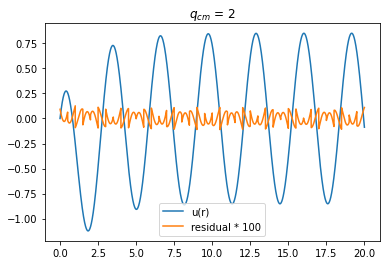

In [113]:
index = 2
plt.plot(r, func[index], label = 'u(r)')
plt.plot(r[ 2:-2], residual[index]*100, label = 'residual * 100')
plt.title(r'$q_{cm}$ = 2')
plt.legend()
plt.show()